In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import random
import math
import torch
import cv2
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from collections import namedtuple
Circle = namedtuple('Circle', ['x', 'y', 'r', 'O', 'c'])
Rectangle = namedtuple('Rectangle', ['x', 'y', 'k', 'a', 'b', 'O', 'c'])
# x & y : any float (location of center of the obstacle)
# r: radius of circle
# k: angle of the rectangle (0 to pi/2)
# a, b: sides of the rectangle
# O, c: opacity and color of the obstacle

# color_map, polar_map -> uint8 array
# opacity_map -> bool array

class Terrain:
    def __init__(self, map_size, initial_location = None):
        self.map_size = map_size
        self.color_map = torch.zeros([map_size, map_size], device = device);
        self.Y,self.X = torch.meshgrid(torch.linspace(1, self.map_size ,self.map_size, device = device), torch.linspace(1, self.map_size ,self.map_size, device = device))
        self.n_circles = 10
        self.n_rectangles = 10
    def initialize_terrain(self):
        self.color_map = torch.zeros([self.map_size, self.map_size], device = device);
        A = [Circle(x = random.randrange(0, self.map_size), 
                    y = random.randrange(0, self.map_size), 
                    r = random.randrange(0, int(self.map_size/2)), 
                    O = bool(random.getrandbits(1)), 
                    c = random.random()) for i in range(self.n_circles)]
        A += [Rectangle(x = random.randrange(0, self.map_size), 
                        y = random.randrange(0, self.map_size), 
                        k = random.uniform(0, math.pi/2), 
                        a = random.uniform(0, self.map_size/2), 
                        b = random.uniform(0, self.map_size/2), 
                        O = bool(random.getrandbits(1)), 
                        c = random.random()) for j in range(self.n_rectangles)]
        self.generate_terrain(A)
    def generate_terrain(self, A):
        for i in A:
            if type(i).__name__ == 'Circle':
                mask = self.circular_obstacle(i)
            elif type(i).__name__ == 'Rectangle':
                mask = self.rectangular_obstacle(i)
            if i.O:
                self.color_map = self.color_map*(~mask)+(i.c*mask)
            else:
                self.color_map = self.color_map*(~mask)
    def circular_obstacle(self, i):
        return (self.X-i.x)**2 + (self.Y-i.y)**2 <= i.r**2
    def rectangular_obstacle(self, i):
        return  torch.logical_and((torch.abs((self.X-i.x)/(math.cos(i.k)+0.001)-(self.Y-i.y)/(math.sin(i.k)+0.001)))<=(i.a*abs(math.tan(i.k)+1/(math.tan(i.k)+0.001))/2),
                               (torch.abs((self.X-i.x)/(math.sin(i.k)+0.001)+(self.Y-i.y)/(math.cos(i.k)+0.001)))<=(i.b*abs(math.tan(i.k)+1/(math.tan(i.k)+0.001))/2))



/home/audrud/mambaforge/envs/torch/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


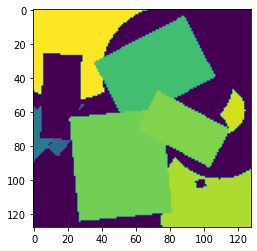

In [3]:
a = Terrain(128)
A = [Rectangle(x = 50, y = 40, k = 0.5, a = 40, b = 40, O = True, c = 80),
     Rectangle(x = 80, y = 20, k = 0.0, a = 40, b = 40, O = False, c = 28),
     Rectangle(x = 180, y = 90, k = 0.8, a = 100, b = 10, O = True, c = 50),
     Circle(x = 130, y = 230, r = 80, O = True, c = 30),
     Circle(x = 100, y = 90, r = 40, O = True, c = 200),
     Circle(x = 30, y = 130, r = 20, O = True, c = 50),]
a.initialize_terrain()
#a.generate_terrain(A)
plt.imshow(a.color_map.T.to('cpu'))


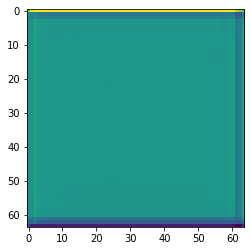

In [4]:
class Simple_AE(nn.Module):
    def __init__(self, map_size):
        super().__init__()
        self.map_size = map_size
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(16, 16, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(16, 16, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            nn.Conv2d(16, 32, 3, stride = 1, padding = 1),
            nn.ReLU(),
            #nn.MaxPool2d(2, stride = 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.ConvTranspose2d(8, 8, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.ConvTranspose2d(8, 8, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.ConvTranspose2d(8, 1, 3, stride = 1, padding = 1),
            #nn.ReLU(),
            #nn.Upsample(scale_factor = 2),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = self.encoder(x)
        #print(x.shape)
        x = self.decoder(x)
        return x

M = Simple_AE(128).to(device)
output = M(torch.ones([1, 1, 64, 64], device = device))
plt.imshow(output.to('cpu').reshape(64,64).detach().numpy())




In [5]:
class Trans_AE(nn.Module):
    def __init__(self, map_size):
        super().__init__()
        # Resnet block based image encoder
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d()
        )

        



In [6]:
batch_size = 64
epoch = 100000
learning_rate = 0.001
t = Terrain(128)
Model = Simple_AE(128).to(device)
optimizer = torch.optim.Adam(Model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()


0.13621542435139417


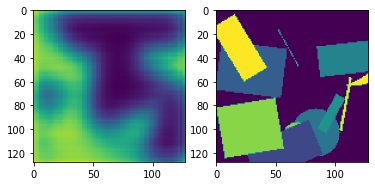

0.033445364367216825


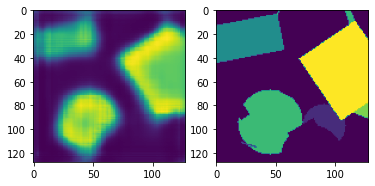

0.015575126660987735


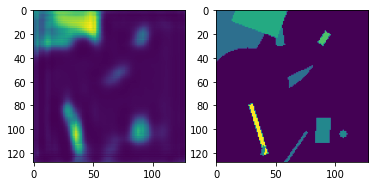

0.013012023353949189


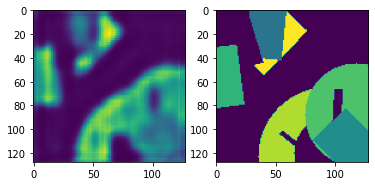

0.012127973912283778


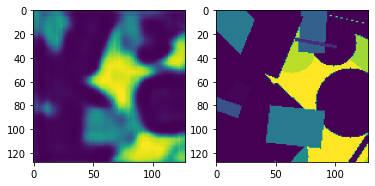

0.011385106472298503


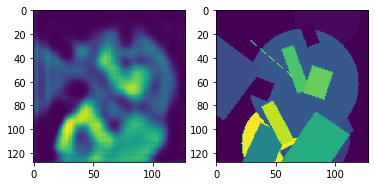

0.010956694018095731


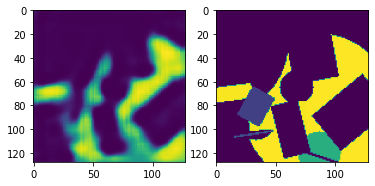

0.010410269936546684


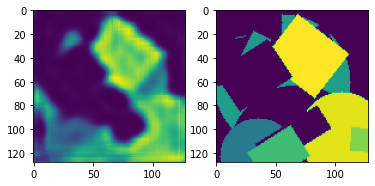

0.009942970061674715


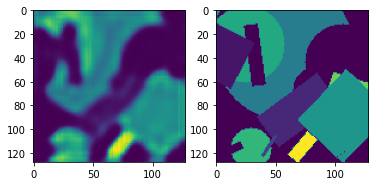

0.009586225589737296


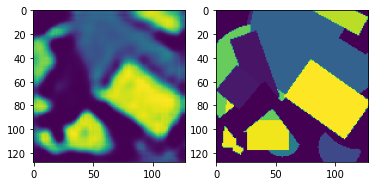

0.009262722544372081


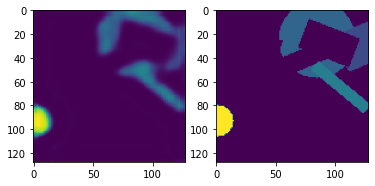

0.008842704608105123


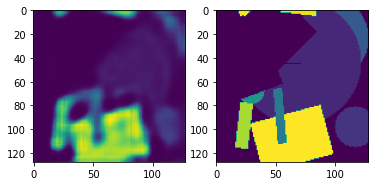

0.008670896850526333


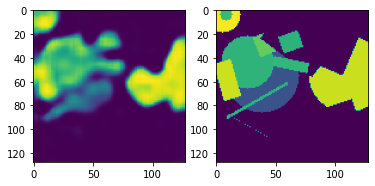

0.008340352377854288


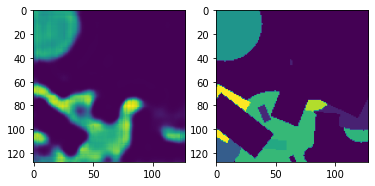

0.008155865282751619


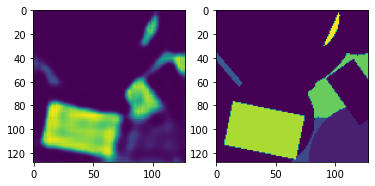

0.00795598077122122


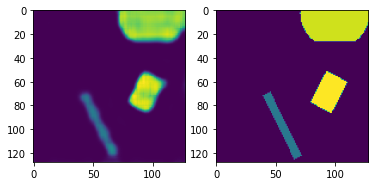

0.007695143707096576


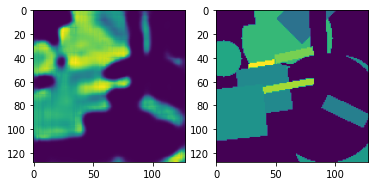

0.007516625081188976


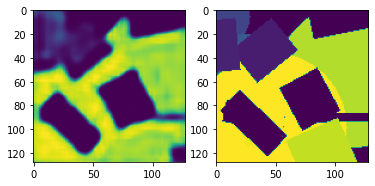

0.007403465895913541


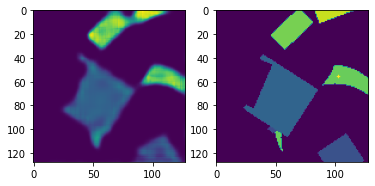

0.007227562726475298


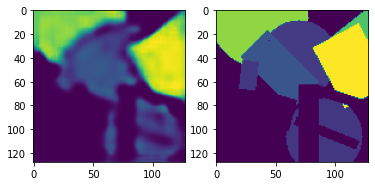

0.007054765122011304


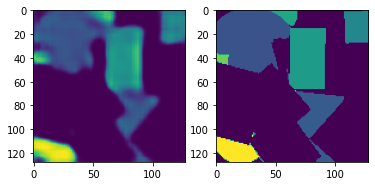

0.0067335808370262385


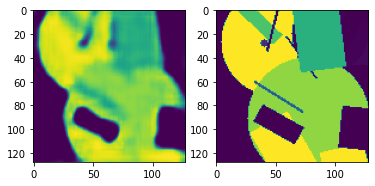

0.006682954295538366


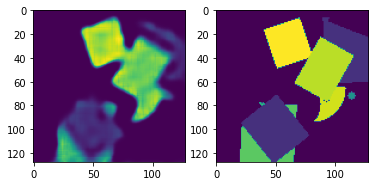

0.006534363785758615


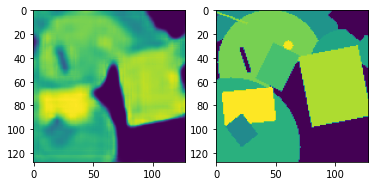

0.006390735898166895


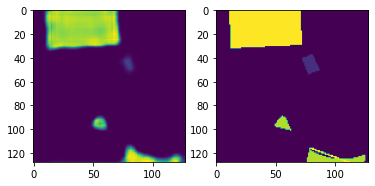

0.0062837185757234695


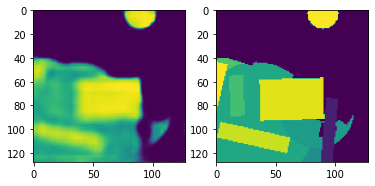

0.006177909215912223


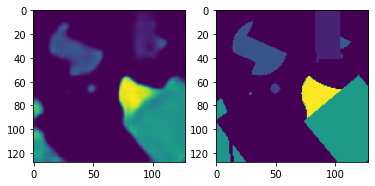

0.006116001652553677


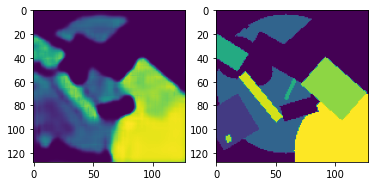

0.005966723063029349


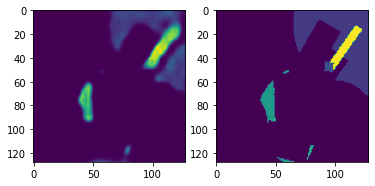

0.005915942918509245


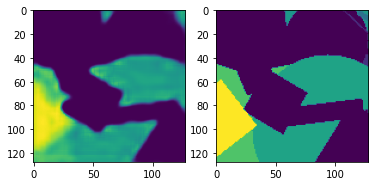

0.0058252373151481155


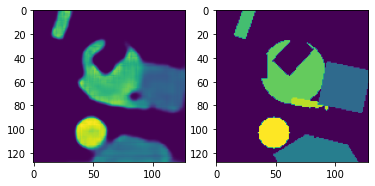

0.005780610772781074


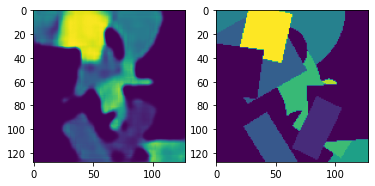

0.005658703069202602


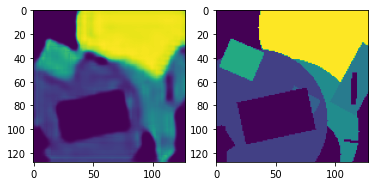

0.005581578491255641


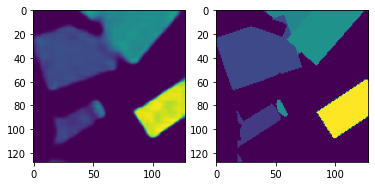

KeyboardInterrupt: 

In [7]:
l_sum = 0
batch = torch.zeros([batch_size, 1, t.map_size, t.map_size], device = device)


for i in range(epoch):
    for j in range(batch_size):
        t.initialize_terrain()
        batch[j] = t.color_map
    optimizer.zero_grad()
    loss = criterion(Model(batch), batch)
    loss.backward()
    optimizer.step()
    l_sum += loss.item()
    
    if i%100 == 0 and i != 0:
        val_input = torch.zeros([1, 1, t.map_size, t.map_size], device = device)
        t.initialize_terrain()
        val_input[0] = t.color_map
        val_output = Model(val_input)
        print(l_sum / 100)
        plt.subplot(1,2,1)
        plt.imshow(val_output.to('cpu').reshape(t.map_size,t.map_size).detach().numpy())
        plt.subplot(1,2,2)
        plt.imshow(val_input.to('cpu').reshape(t.map_size,t.map_size).detach().numpy())
        plt.show()
        l_sum = 0
    
    
